# Fatbox for Analogue Modelling - Fault Evolution - tuto 3/6

This example follows [Tutorial B1] and [Tutorial B2], which describe how to extract a 2-D fault network from an analogue model simulating orthogonal continental rifting.

The first cells are taken from previous tutorials, but do not contain any explanation of what each step does. Please refer to the corresponding tutorials for further details.

The analog models are based on the study of Molnar et al. (2017)

### Load packages + Extract and clean network + Compute fault throw



In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip3 install earthpy
!pip install cv-algorithms
!pip install vtk

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 83.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cv-algorithms: filename=cv_algorithms-1.1.1-cp311-cp311-manylinux_2_35_x86_64.whl size=40948 sha256=089972ef6f928706f555ac14f210834ef3f4860b67a2c4e423839754cdb27a31
  Stored in directory: /root/.cache/pip/wheels/6d/fc/8d/7dc6a93ee79ff25fd3491eac76e255cca24893bb3d5f3cc150
Successfully built cv-algorithms
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 MB 7.9 MB/s eta 0:00:00


Import of the packages and Fatbox

In [2]:
import numpy as np
import networkx as nx
import cv2

import copy

import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from skimage import data, io, filters, measure, feature, color, morphology
from skimage.morphology import skeletonize
from skimage.util import invert, img_as_ubyte

from scipy.spatial import distance_matrix
from scipy import interpolate
from scipy.interpolate import griddata
from scipy.signal import fftconvolve, savgol_filter
from scipy import ndimage as ndi

from numpy import array

from ipywidgets import Layout, interactive, widgets
from tqdm import tqdm

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
#

from pathlib import Path #The gestion of Path with pathlib allows for universal use.
import os
path_folder=Path('/content/drive/MyDrive/Fatbox')
path_modules=path_folder/'modules'
#print(path_folder) #make sure path_folder = '/Fatbox/modules'
os.chdir(path_modules) # make modules as working directory
#type pwd in console and make sure it is '/Fatbox/modules'

import preprocessing
import metrics
import plots
import utils
import structural_analysis
import edits


save_plots=False
loc_plots=Path(path_folder/'tutorials'/'analog'/'plots'/'B2')
my_dpi=100

if not (path_folder/'tutorials'/'analog'/'plots'/'B3').is_dir():
    (path_folder/'tutorials'/'analog'/'plots'/'B3').mkdir(parents=True,exist_ok=True)

Import of the data

In [3]:
path_input=Path('/content/drive/MyDrive/Fatbox/tutorials/analog/data_analog')

dems = [] #all dem arrays will be stored here

for n in range(1,17): #because there are 16 arrays, dem1.npy through dem16.npy
  data = np.load((path_input/str('dem' + str(n) + '.npy')))
  data = data[:,:-1] #added this line because the canny edge detection algorithm was generating an unreal 'fault' in the right hand side of the arrays
  dems.append(data)

#We define a few variables to calculate a hillshade for our DEMs
az = 300 #azimuth of the light for the hillshade
alt = 1 #altitute (degrees) of the light for the hillshade

def gaussian_blur(in_array, size):
    # expand in_array to fit edge of kernel
    padded_array = np.pad(in_array, size, 'symmetric')
    # build kernel
    x, y = np.mgrid[-size:size + 1, -size:size + 1]
    g = np.exp(-(x**2 / float(size) + y**2 / float(size)))
    g = (g / g.sum()).astype(in_array.dtype)
    # do the Gaussian blur
    return fftconvolve(padded_array, g, mode='valid')

blurfact = 12 #the higher this number is, the more we will smooth the DEM
blurdems = [] #create a list where blurred dems will be stored

for n in range(0,16): #because there are 16 arrays
  blurdem = gaussian_blur(dems[n], blurfact)
  blurdems.append(blurdem)

### START DEFINING FUNCTIONS ###

# function 1
def mystrike(x1, y1, x2, y2):
  if (x2-x1)<0:
    strike = math.degrees(math.atan2((x2-x1),(y2-y1))) + 360
  else:
    strike = math.degrees(math.atan2((x2-x1),(y2-y1)))

  #Scale to [0, 180]
  if strike<=180:
    return strike
  else:
    return strike - 180

#function 2
def calculate_mystrike(G, non):
    """ Compute strike of fault network

    Parameters
    ----------
    G : nx.graph
        Graph containing edges
    non: int
        Number of neighbors

    Returns
    -------
    G : nx.graph
        Graph containing edges with 'strike' attribute
    """

    # Assertions
    assert isinstance(G, nx.Graph), 'G is not a NetworkX graph'

    for node in tqdm(G, desc='Calculate mystrike'):


        neighbors = nx.single_source_shortest_path_length(G, node, cutoff=non)


        neighbors = sorted(neighbors.items())

        first = neighbors[0][0]
        last = neighbors[-1][0]

        # print(node)
        # print(neighbors)
        # print(first, last)



        x1 = G.nodes[first]['pos'][0]
        y1 = G.nodes[first]['pos'][1]

        x2 = G.nodes[last]['pos'][0]
        y2 = G.nodes[last]['pos'][1]


        G.nodes[node]['strike'] = mystrike(x1, y1, x2, y2)


    for edge in G.edges:
        G.edges[edge]['strike'] = (G.nodes[edge[0]]['strike'] + G.nodes[edge[0]]['strike'])/2

    return G

#function 3
def calculate_diff_strike(G, non):
    """ Compute strike difference between nodes of fault network

    Parameters
    ----------
    G : nx.graph
        Graph containing edges
    non: int
        Number of neighbors

    Returns
    -------
    G : nx.graph
        Graph containing nodes with 'strike' attribute
    """


    # Assertions
    assert isinstance(G, nx.Graph), 'G is not a NetworkX graph'


    for node in G:

        neighbors = nx.single_source_shortest_path_length(G, node, cutoff=non)
        #print(neighbors)
        #print(len(neighbors))
        strikes = [G.nodes[node]['strike'] for node in neighbors.keys()]
        #print(strikes)
        #print(len(strikes))
        if len(neighbors) > 1:
          G.nodes[node]['strike_diff'] = np.max(np.diff(strikes))
        else:
          G.nodes[node]['strike_diff'] = np.nan


    return G

# function 4

def remove_nodes_between(G, attribute, low, high):
    """ Remove node with attribute between two values

    Parameters
    ----------
    G : nx.graph
        Graph
    attribute : str
        Attribute
    low : float
        lower value
    high : float
        higher value

    Returns
    -------
    G : nx.graph
        Graph
    """
    removals = []
    # Assertions
    assert isinstance(G, nx.Graph), "G is not a NetworkX graph"

    # Calculation
    for node in G.nodes:
        if G.nodes[node][attribute] >= low and G.nodes[node][attribute] <= high:
            removals.append(node)

    G.remove_nodes_from(removals)

    return G

def get_nodes(G):
    labels = metrics.get_fault_labels(G)
    point_set=[]
    for label in labels:
        G_fault = metrics.get_fault(G, label)
        points = []
        for node in G_fault:
            points.append(G_fault.nodes[node]['pos'])
        point_set.append(points)
    return point_set


def compute_similarity(set_A, set_B):
      distances = np.zeros((len(set_A), len(set_B)))
      for n, pt_0 in enumerate(set_A):
          for m, pt_1 in enumerate(set_B):
              distances[n,m] = math.sqrt((pt_0[0]-pt_1[0])**2 + (pt_0[1]-pt_1[1])**2)
      return np.mean(np.min(distances, axis=1))


def correlation_slow(G_0, G_1, R):
    # A function which labels the faults in G_1 according to G_0 using the
    # minimum radius R

    # Get labels and nodes
    fault_labels_0 = metrics.get_fault_labels(G_0)
    fault_labels_1 = metrics.get_fault_labels(G_1)

    nodes_0 = get_nodes(G_0)
    nodes_1 = get_nodes(G_1)

    # Compute similarities
    smf = np.zeros((len(fault_labels_0), len(fault_labels_1)))
    smb = np.zeros((len(fault_labels_1), len(fault_labels_0)))

    for n in tqdm(range(len(fault_labels_0)), desc='   Compute similarities'):
        for m in range(len(fault_labels_1)):
            smf[n,m] = compute_similarity(nodes_0[n], nodes_1[m])
            smb[m,n] = compute_similarity(nodes_1[m], nodes_0[n])

    # Determine correlations
    correlations = set()
    for n in tqdm(range(len(fault_labels_0)), desc='   Find correlations'):
        for m in range(len(fault_labels_1)):
            if smf[n,m] < R:
                correlations.add((fault_labels_0[n], fault_labels_1[m]))
            if smb[m,n] < R:
                correlations.add((fault_labels_0[n], fault_labels_1[m]))

    return correlations, smf, smb

def G_to_pts(G):
    labels = get_fault_labels(G)
    point_set=[]
    for label in labels:
        G_fault = metrics.get_fault(G, label)
        points = []
        for node in G_fault:
            points.append(G_fault.nodes[node]['pos'])
        point_set.append(points)
    return point_set

def is_A_in_B(set_A, set_B, R):
      distances = np.zeros((len(set_A), len(set_B)))
      for n, pt_0 in enumerate(set_A):
          for m, pt_1 in enumerate(set_B):
              distances[n,m] = math.sqrt((pt_0[0]-pt_1[0])**2 + (pt_0[1]-pt_1[1])**2)
      if np.mean(np.min(distances, axis=1)) > R:
          return False
      else:
          return True

def relabel(G_1, correlations):

    # A function, which relabels G_1 using the correlations
    for node in G_1:
        G_1.nodes[node]['correlated']=0

    lengths = [metrics.total_length(metrics.get_fault(G_0, correlation[0]), calculate=True) for correlation in correlations]
    lengths, correlations = zip(*sorted(zip(lengths, correlations)))


    for node in G_1:
        for correlation in correlations:
            if G_1.nodes[node]['component'] == correlation[1]:
                G_1.nodes[node]['fault'] = correlation[0]
                G_1.nodes[node]['correlated'] = 1

    max_comp = max(get_fault_labels(G_1))

    G_1_sub = nx.subgraph(G_1, [node for node in G_1 if G_1.nodes[node]['correlated']==0])
    for label, cc in enumerate(sorted(nx.connected_components(G_1_sub))):
        for n in cc:
            G_1.nodes[n]['fault'] = label+max_comp+1

    return G_1

### DONE DEFINING FUNCTIONS ###

G_dem = [] #all graphs derived from DEM arrays will be stored here

#define factors and parameters. These parameters can and should be modified depending on the dataset. You can manually vary them and compare the results!
sigma = 2.7 #2.5 original value, worked fine, don't erase
lowth = 0.15 #0.15 original value, worked fine, don't erase
highth = 0.2 #0.2 original value, worked fine, don't erase

non1 = 2 #number of neighbour edges taken into account to calculate edge strike
non2 = 12 #number of neighbour edges taken into account to calculate edge strike difference
f_thr = 45 #fault length threshold

for n in range(0,16):

  print('')
  print('Timestep ' + str(n+1) + '/16')
  print('Experiment time: ' + str((n+3)*30) + ' minutes') #Start printing a little summary for each timestep

  blurdem = gaussian_blur(dems[n], blurfact) #grab dem data and apply blur filter
  faults = feature.canny(blurdem, sigma=sigma, low_threshold=lowth, high_threshold=highth) #run canny edge detection
  faultsx = img_as_ubyte(faults) #convert faults arrays to another format, otherwise the skeleton fx won't work
  skeleton = preprocessing.skeleton_guo_hall(faultsx) #skeletonize the image we created after applying the canny edge detection
  ret, markers = cv2.connectedComponents(skeleton) #get connected components from the skeletonised image
  points = preprocessing.array_to_points(skeleton) #convert lines to points

  G = nx.Graph() #create empty graph where nodes obtained from the skeletonized image will be stored

  node = 0
  for comp in range(1,ret):
    points = np.transpose(np.vstack((np.where(markers==comp))))

    for point in points:
        G.add_node(node)
        G.nodes[node]['pos'] = (point[1], point[0])
        G.nodes[node]['component'] = comp
        node += 1

  for comp in range(1,ret):

    points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
    nodes  = [node for node in G if G.nodes[node]['component']==comp]

    dm = distance_matrix(points, points)

    for o in range(len(points)):

        for m in range(len(points)):
            if dm[o,m]<1.5 and o != m:
                G.add_edge(nodes[o],nodes[m])

  for node in list(G.nodes()):
    if G.degree(node) == 3 or G.degree(node) == 4 or G.degree(node) == 5: #remove nodes with 3, 4, 5 edges
        edges = list(G.edges(node))
        G.add_edge(edges[0][1], edges[1][1])
        G.remove_node(node)

  G = calculate_mystrike(G, non1) #we calculate the strike for each node/edge
  G = calculate_diff_strike(G, non2) #we calculate the difference in strike between one edge and the neighbour edge at distance=non2 (number of neighbours)
  G = remove_nodes_between(G, attribute='strike_diff', low=60, high=120) #remove all nodes that have a strike difference between 'low' and 'high'

  G = edits.label_components(G)

  for node in G:
    G.nodes[node]['fault'] = G.nodes[node]['component'] #make component ID and fault ID match

  def get_fault_labels(G):
    labels=set()
    for nodex in G:
        labels.add(G.nodes[nodex]['fault'])
    return sorted(list(labels))

  fault_labels = metrics.get_fault_labels(G)

  f_len = metrics.calculate_fault_lengths(G, mode='get') #get fault lengths for cleaning them by length in the following step
  f_id_clean = np.argwhere(f_len<f_thr) #get faults with a length smaller than the threshold

  #print a little summary of each timestep to see how things are working out
  print("Total number of faults: " + str(len(f_len)))
  print("Faults shorter than " + str(f_thr) + " : " + str(len(f_id_clean)))
  print("Remaining faults: " + str(len(f_len)-len(f_id_clean)))

  for e in range(len(f_id_clean)): #number of times we are going to loop this, which is the number of faults that meet our condition
    fid = f_id_clean.item(e) #get a temporary variable, fid = fault id
    for node in G.copy():
      if G.nodes[node]['fault'] == fid: #if the fault id's match
        G.remove_node(node) #remove all nodes associated to that fault id

  G = edits.label_components(G)

  G_dem.append(G) #after finishing this loop, adds the new graph to the G_dem list


Timestep 1/16
Experiment time: 90 minutes


Calculate mystrike: 100%|██████████| 2406/2406 [00:00<00:00, 51598.58it/s]


Total number of faults: 183
Faults shorter than 45 : 176
Remaining faults: 7

Timestep 2/16
Experiment time: 120 minutes


Calculate mystrike: 100%|██████████| 2530/2530 [00:00<00:00, 56189.68it/s]


Total number of faults: 187
Faults shorter than 45 : 182
Remaining faults: 5

Timestep 3/16
Experiment time: 150 minutes


Calculate mystrike: 100%|██████████| 2501/2501 [00:00<00:00, 98271.15it/s]


Total number of faults: 190
Faults shorter than 45 : 185
Remaining faults: 5

Timestep 4/16
Experiment time: 180 minutes


Calculate mystrike: 100%|██████████| 2600/2600 [00:00<00:00, 65436.51it/s]


Total number of faults: 198
Faults shorter than 45 : 194
Remaining faults: 4

Timestep 5/16
Experiment time: 210 minutes


Calculate mystrike: 100%|██████████| 3087/3087 [00:00<00:00, 84565.45it/s]


Total number of faults: 230
Faults shorter than 45 : 226
Remaining faults: 4

Timestep 6/16
Experiment time: 240 minutes


Calculate mystrike: 100%|██████████| 3791/3791 [00:00<00:00, 104221.85it/s]


Total number of faults: 232
Faults shorter than 45 : 216
Remaining faults: 16

Timestep 7/16
Experiment time: 270 minutes


Calculate mystrike: 100%|██████████| 4995/4995 [00:00<00:00, 106443.60it/s]


Total number of faults: 283
Faults shorter than 45 : 260
Remaining faults: 23

Timestep 8/16
Experiment time: 300 minutes


Calculate mystrike: 100%|██████████| 5774/5774 [00:00<00:00, 63775.65it/s]


Total number of faults: 251
Faults shorter than 45 : 220
Remaining faults: 31

Timestep 9/16
Experiment time: 330 minutes


Calculate mystrike: 100%|██████████| 6455/6455 [00:00<00:00, 108607.55it/s]


Total number of faults: 225
Faults shorter than 45 : 200
Remaining faults: 25

Timestep 10/16
Experiment time: 360 minutes


Calculate mystrike: 100%|██████████| 7336/7336 [00:00<00:00, 85554.72it/s]


Total number of faults: 217
Faults shorter than 45 : 196
Remaining faults: 21

Timestep 11/16
Experiment time: 390 minutes


Calculate mystrike: 100%|██████████| 7963/7963 [00:00<00:00, 110560.20it/s]


Total number of faults: 224
Faults shorter than 45 : 197
Remaining faults: 27

Timestep 12/16
Experiment time: 420 minutes


Calculate mystrike: 100%|██████████| 8673/8673 [00:00<00:00, 108834.91it/s]


Total number of faults: 271
Faults shorter than 45 : 248
Remaining faults: 23

Timestep 13/16
Experiment time: 450 minutes


Calculate mystrike: 100%|██████████| 9145/9145 [00:00<00:00, 106618.64it/s]


Total number of faults: 246
Faults shorter than 45 : 218
Remaining faults: 28

Timestep 14/16
Experiment time: 480 minutes


Calculate mystrike: 100%|██████████| 9555/9555 [00:00<00:00, 111364.65it/s]


Total number of faults: 263
Faults shorter than 45 : 239
Remaining faults: 24

Timestep 15/16
Experiment time: 510 minutes


Calculate mystrike: 100%|██████████| 10093/10093 [00:00<00:00, 108371.65it/s]


Total number of faults: 255
Faults shorter than 45 : 226
Remaining faults: 29

Timestep 16/16
Experiment time: 540 minutes


Calculate mystrike: 100%|██████████| 10640/10640 [00:00<00:00, 108921.69it/s]


Total number of faults: 310
Faults shorter than 45 : 283
Remaining faults: 27


Correlation
See numerical modelling tutorials for more details

In [4]:
R = 12 #Modify this value and check best results

for n, time in enumerate(range(0,len(G_dem)-1)): #loop through all timesteps, stop one before the end because it would create a size error
  print('Timesteps ' + str(time+1) + '-' + str(time+2) + '/16')
  G_0 = G_dem[time]
  G_1 = G_dem[time+1]

  if n == 0: # Only do this for the first correlation
    for node in G_0:
      G_0.nodes[node]['fault'] = G_0.nodes[node]['component']

  for node in G_1:
    G_1.nodes[node]['fault'] = G_1.nodes[node]['component']

  correlations, smf, smb = correlation_slow(G_0, G_1, R=R)
  G_1 = relabel(G_1, correlations)

  G_dem[time+1] = G_1

Timesteps 1-2/16


   Find correlations: 100%|██████████| 7/7 [00:00<00:00, 3524.20it/s]


Timesteps 2-3/16


   Find correlations: 100%|██████████| 5/5 [00:00<00:00, 25358.55it/s]


Timesteps 3-4/16


   Find correlations: 100%|██████████| 5/5 [00:00<00:00, 13990.34it/s]


Timesteps 4-5/16


   Find correlations: 100%|██████████| 4/4 [00:00<00:00, 931.96it/s]


Timesteps 5-6/16


   Find correlations: 100%|██████████| 4/4 [00:00<00:00, 17867.11it/s]


Timesteps 6-7/16


   Find correlations: 100%|██████████| 16/16 [00:00<00:00, 33058.55it/s]


Timesteps 7-8/16


   Find correlations: 100%|██████████| 23/23 [00:00<00:00, 27554.70it/s]


Timesteps 8-9/16


   Find correlations: 100%|██████████| 29/29 [00:00<00:00, 35083.59it/s]


Timesteps 9-10/16


   Find correlations: 100%|██████████| 25/25 [00:00<00:00, 28432.10it/s]


Timesteps 10-11/16


   Find correlations: 100%|██████████| 20/20 [00:00<00:00, 22832.36it/s]


Timesteps 11-12/16


   Find correlations: 100%|██████████| 26/26 [00:00<00:00, 36705.45it/s]


Timesteps 12-13/16


   Find correlations: 100%|██████████| 21/21 [00:00<00:00, 30668.66it/s]


Timesteps 13-14/16


   Find correlations: 100%|██████████| 27/27 [00:00<00:00, 47783.21it/s]


Timesteps 14-15/16


   Find correlations: 100%|██████████| 22/22 [00:00<00:00, 31984.29it/s]


Timesteps 15-16/16


   Find correlations: 100%|██████████| 27/27 [00:00<00:00, 41165.47it/s]


Steps from Tutorial B2 end here. Up to this point, we should end up with all the fault networks corresponding to each timestep already stored in a single variable, G_dem

______


Now we can explore our graphs further and see how we can visualise more information.


We can start with basic things such as looking at fault lengths. For example, this is how we get the fault lengths from G at any time step:

In [5]:
time = 12
G = G_dem[time]

metrics.calculate_fault_lengths(G, mode='get') #get fault lengths

array([ 415.29646456,  378.59797975,   58.04163056, 1047.4629868 ,
        776.59292911,  730.61579365,  290.95331881, 1015.22034611,
        327.50966799,  146.84062043,   87.87005769,  207.42640687,
        249.49747468,  205.49747468,   45.3137085 ,   89.72792206,
         87.55634919,  102.04163056,   55.55634919,  105.6919121 ,
         75.79898987,   59.3137085 ,   45.24264069,   46.48528137,
         49.14213562,   67.11269837,   58.87005769])

However, this 'length' is deceptive, as it is a unitless value, obtained as the sum of all the lengths of the network 'edges' within a fault (regular grid, two non-diagonal neighbour nodes are at a length = 1). We have to convert it to mm or something more meaningful.

We need a conversion factor. In this dataset, each data point was originally at 0.36 mm from each other, so we apply that conversion:

In [6]:
time = 15
G = G_dem[time]

metrics.calculate_fault_lengths(G, mode='get')*0.36 #get fault lengths in mm

array([145.45937659, 137.52438959, 377.08667525, 276.07140254,
       273.52581813, 127.89612983, 345.39607784, 131.28524671,
        61.14262336,  21.65116882, 123.15436359, 120.34672724,
       166.42672724,  42.88057141, 159.19054542,  38.28792206,
        33.95293506,  17.69116882,  20.44763635,  20.38587012,
        22.88028571,  20.39646753,  19.03322077,  17.12028571,
        30.57880518])

Now it makes more sense. In this particular example, the area of the analogue modelling box we are visualising is 40 cm (top to bottom), so the longest fault that runs across the entire model shouldn't exceed this value.

## 1. Creating pick-up points

We have to see how to extract fault data such as throw or vertical displacement.

First step is to calculate the directions of the fault *(See [Tutorial A4](https://github.com/thilowrona/fatbox_tutorials/blob/main/Numerical_models/4-fault_slip/4-fault_slip.ipynb))* in order to calculate 'pick-up' points. This is the function we will use:

In [7]:
def calculate_direction(G, cutoff, normalize=True):
    """ Calculate direction for entire network

    Parameters
    ----------
    G : nx.graph
        Fault network
    cutoff : int, float
        Cutoff distance for direction
    normalize : bolean
        Normalize direction (default: True)

    Returns
    -------
    G
        nx.graph
    """

    # Assertions
    assert isinstance(G, nx.Graph), 'G is not a NetworkX graph'

    # Calculation
    for node in G.nodes:

        length = nx.single_source_shortest_path_length(G, node, cutoff=cutoff)
        keys = [keys for keys, values in length.items() if values == max(length.values())]

        if len(keys) > 2:
            (node_0, node_1) = keys[:2]

        if len(keys) == 2:
            (node_0, node_1) = keys
        if len(keys) == 1:
            node_0 = keys[0]

            length = nx.single_source_shortest_path_length(G, node, cutoff=cutoff - 1)
            keys = [keys for keys, values in length.items() if values == max(length.values())]

            node_1 = keys[0]

        # here the directions are made consistently for N-S trending faults
        if G.nodes[node_0]['pos'][1] < G.nodes[node_1]['pos'][1]:
          pt_0 = G.nodes[node_0]['pos']
          pt_1 = G.nodes[node_1]['pos']
        else:
          pt_0 = G.nodes[node_1]['pos']
          pt_1 = G.nodes[node_0]['pos']

        # calculate vector
        dx = pt_0[0] - pt_1[0]
        dy = pt_0[1] - pt_1[1]

        # write to graph
        G.nodes[node]['dx'] = dx
        G.nodes[node]['dy'] = dy

    return G

#G = calculate_direction(G, cutoff=3) #this is how we would calculate direction for network G. We will apply this function in a loop in a moment.

And this is the function to calculate the pick-up points:

In [8]:
def calculate_pickup_points(G, factor):

    H = nx.Graph() #create empty graph where the new one with the pick-up points will be stored

    for node in G.nodes:

        (x, y) = G.nodes[node]['pos']

        dx = G.nodes[node]['dx']
        dy = G.nodes[node]['dy']

        dx = factor * dx
        dy = factor * dy

        x_p = int(x - dy)
        y_p = int(y + dx)

        x_n = int(x + dy)
        y_n = int(y - dx)

        node_p = (node, 1)
        H.add_node(node_p)
        H.nodes[node_p]['pos'] = (x_p, y_p)
        H.nodes[node_p]['component']  = -2
        H.nodes[node_p]['fault']  = G.nodes[node]['fault'] #assign the fault ID to the H nodes

        node_n = (node, 2)
        H.add_node(node_n)
        H.nodes[node_n]['pos'] = (x_n, y_n)
        H.nodes[node_n]['component']  = -3
        H.nodes[node_n]['fault']  = G.nodes[node]['fault'] #assign the fault ID to the H nodes

        H.add_edge(node_n, node_p)

    return H

#H = calculate_pickup_points(G, 0.7)  #this is how to run the function to calculate the pick-up for a graph G, we will run it later in a loop for all graphs
#the 0.7 value can be adjusted. The larger it is, the longer is the distance between the pick-up points.

The previous cells define the functions and apply it to a single graph, G. But we need to apply it to ALL graphs, for all timesteps:

In [9]:
Ps = [] #profiles with fault elevation difference (not throw) will be stored here, at this stage it is just the pick-up points network
for time in range(len(G_dem)):

  G = G_dem[time]
  G = calculate_direction(G,cutoff=3)
  G = calculate_pickup_points(G, 1) #ADJUST IF NECESSARY
  Ps.append(G) #append the new graph with pick-up points to the list Ps

Plot to see what is going on:

In [10]:
def f(time):
    H = Ps[time] #grab graph corresponding to each timestep

    fig, axs = plt.subplots(1, 1, figsize=(6,12)) #set up plot

    axs.set_title('Pick-up points + DEM')
    axs.imshow(dems[time], 'gist_earth', vmin=-8, vmax=2, alpha=0.4)
    axs.set_ylim([1000,0])
    axs.set_xlim([0,400])
    plots.plot_faults(H, node_size=1, ax=axs, label=False)
    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=0, max=15, step=1, layout=Layout(width='700px')))
output = interactive_plot.children[-1]
output.layout.width = '800px'
interactive_plot

interactive(children=(IntSlider(value=0, description='time', layout=Layout(width='700px'), max=15), Output(lay…

We can't understand much. Let's zoom in:

In [11]:
def f(time):
    H = Ps[time] #grab graph corresponding to each timestep

    fig, axs = plt.subplots(1, 1, figsize=(6,12)) #set up plot

    axs.set_title('Zoomed in pick-up points + DEM ')
    axs.imshow(dems[time], 'gist_earth', vmin=-8, vmax=2, alpha=0.4)
    plots.plot_faults(H, node_size=10, ax=axs, label=False) #then we plot them
    axs.set_xlim([130, 80]) #Adjust if a different area needs to be zoomed in
    axs.set_ylim([800, 900]) #Adjust if a different area needs to be zoomed in
    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=0, max=15, step=1, layout=Layout(width='700px')))
output = interactive_plot.children[-1]
output.layout.width = '800px'
interactive_plot

interactive(children=(IntSlider(value=0, description='time', layout=Layout(width='700px'), max=15), Output(lay…

OK now we understand what these pick-up point are.

# 2. Computing and extracting fault throw

We are going to use these pick-up points to get a profile with elevation data, then calculate the elevation difference, and store it back into the fault network as an attribute for each node.

First we do it for a single timestep to understand how this is done:

In [12]:
time = 15 #choose any timestep

P_up = Ps[time]
DEM = blurdems[time]
G_clean = G_dem[time]

P_up = metrics.extract_attribute(P_up, DEM, 'elevation') #this function collects values from the second argument based on the location of the first argument, and saves it as a new attribute
for node in G_clean: #then we calculate the difference
  G_clean.nodes[node]['difference'] = P_up.nodes[(node,1)]['elevation'] - P_up.nodes[(node,2)]['elevation']

To test what we have just done, we can plot the fault network, coloured based on the elevation difference:

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

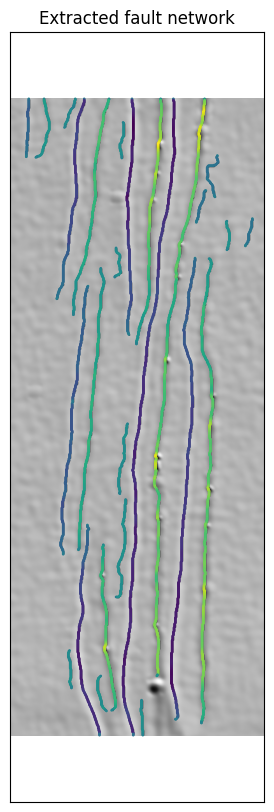

In [13]:
# Plot arrays
fig, ax = plt.subplots(1, 1, figsize=(6,10), sharey=False)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)

ep.plot_bands(
    hillshade, cbar=False, title="Extracted fault network", figsize=(6, 10), ax=ax,
)
plots.plot_attribute(G_clean, 'difference', colorbar=True, ax=ax)

ax.set_xlim([0, DEM.shape[1]])
ax.set_ylim([DEM.shape[0], 0])

plt.show()

Now we can use this difference to determine the dip direction for the throw calculation. First we calculate the mean difference for each fault, i.e. component:

In [14]:
for comp in nx.connected_components(G_clean):
  value = np.mean([G_clean.nodes[node]['difference'] for node in comp])
  for node in comp:
    G_clean.nodes[node]['mean_difference'] = value

Then the dip direction:

In [15]:
threshold = 0.1
for comp in nx.connected_components(G_clean):
  value = np.mean([G_clean.nodes[node]['difference'] for node in comp])
  if value > threshold:
    for node in comp:
      G_clean.nodes[node]['dip_dir_auto'] = -1
  elif value < -threshold:
    for node in comp:
      G_clean.nodes[node]['dip_dir_auto'] = 1
  else:
    for node in comp:
      G_clean.nodes[node]['dip_dir_auto'] = 0

And we plot it to see if it makes sense. Border faults in our grabens should have different colours

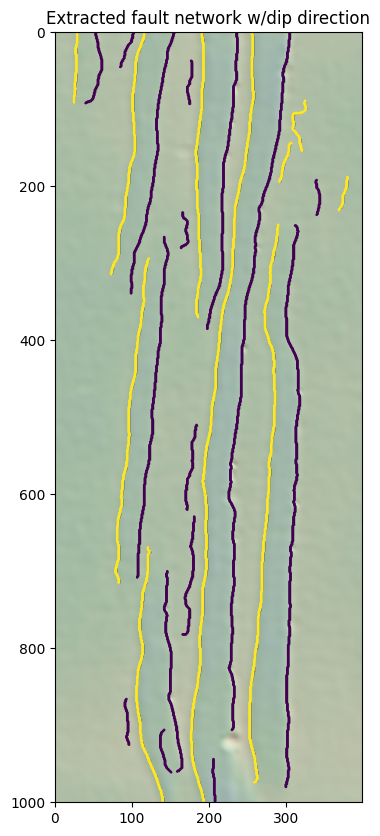

In [16]:
# Plot arrays
fig, ax = plt.subplots(1, 1, figsize=(6,10), sharey=False)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)

ax.imshow(DEM, 'gist_earth', vmin=-8, vmax=2, alpha=0.4)
ax.imshow(hillshade, 'Greys', alpha=0.3)
ax.set_title('Extracted fault network w/dip direction')
#ep.plot_bands(
#    hillshade, cbar=False, title="Extracted fault network", figsize=(6, 10), ax=ax,
#)
plots.plot_attribute(G_clean, 'dip_dir_auto', colorbar=False, ax=ax)

ax.set_xlim([0, DEM.shape[1]])
ax.set_ylim([DEM.shape[0], 0])

plt.show()

Next we define the key function that will grab the throws for each fault:

In [17]:
def get_throws(G, DEM, factor, dip_dir_auto=[], plot_profiles=False):

    '''G = Graph
    DEM = Digital elevation model as numpy array
    factor = across-fault profile length
    dip_dir = fault dip direction. It consider just E- and W-dipping faults.
    Alternatively you can avoid to specify this option '''

    # Assertions
    assert isinstance(DEM, np.ndarray), 'DEM is not a NumPy array'
    for node in G:

        (x, y) = G.nodes[node]['pos']

        dx = G.nodes[node]['dx']
        dy = G.nodes[node]['dy']

        dx = factor * dx
        dy = factor * dy

        x_p = int(x - dy)
        y_p = int(y + dx)

        x_n = int(x + dy)
        y_n = int(y - dx)

        if x_p < 0:
            x_p = 0

        if x_p >= DEM.shape[1]:
            x_p = DEM.shape[1]-1

        if y_p < 0:
            y_p = 0

        if y_p >= DEM.shape[0]:
            y_p = DEM.shape[0]-1

        if x_n < 0:
            x_n = 0

        if x_n >= DEM.shape[1]:
            x_n = DEM.shape[1]-1

        if y_n < 0:
            y_n = 0

        if y_n >= DEM.shape[0]:
            y_n = DEM.shape[0]-1


        n = 100

        '''dx and dy vary in sign and this can cause a wrong profile extraction.
        The following lines take this into account to extract always the right
        profile on the basis of the fault dip direction and dx, dy positions.'''

        '''This is for W-dipping faults. It extracts asymmetric profiles'''
        if G.nodes[node]['dip_dir_auto'] == -1:
                xl, yl = np.linspace(x_p-factor, x_n-(factor*4), n), np.linspace(y_p+factor, y_n+(factor*4), n)

        '''this is for E-dipping faults. It extracts asymmetric profiles'''
        if G.nodes[node]['dip_dir_auto'] == 1:
                xl, yl = np.linspace(x_p+(factor*4), x_n+factor, n), np.linspace(y_p-(factor*4), y_n-factor, n)

        '''this is for no dip fault. It extracts symmetric profiles'''
        if G.nodes[node]['dip_dir_auto'] == 0:
                xl, yl = np.linspace(x_p, x_n, n), np.linspace(y_p, y_p, n)

        if plot_profiles:
          plt.plot(xl, yl)

        # Extract the values along the line
        values = np.zeros(n)

        for n, (x, y) in enumerate(zip(xl,yl)):
            if x < 0 or x >= DEM.shape[1]:
              values[n] = float('nan')
            elif y < 0 or y >= DEM.shape[0]:
              values[n] = float('nan')
            else:
              values[n] = DEM[int(y),int(x)]

        # Compute minimum/maximum
        minimum = np.nanpercentile(values, 5)
        maximum = np.nanpercentile(values, 95)

        # Write throw to graph
        G.nodes[node]['throw'] = maximum - minimum

    return G

G_clean = get_throws(G_clean, DEM, 1, plot_profiles=False)

/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


And now plot again, but instead of **Elevation difference**, we are going to colour each fault trace with their **Throw** value:

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

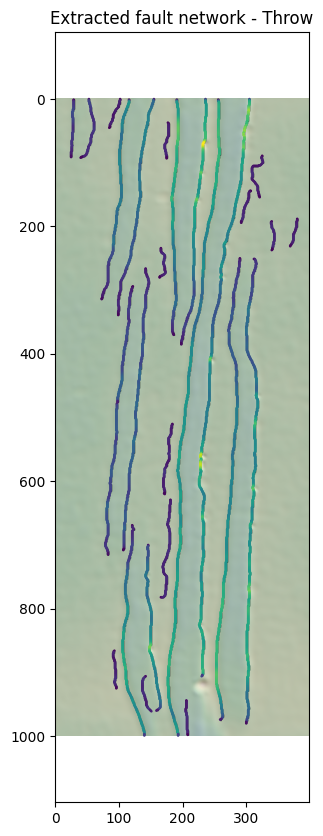

In [18]:
# Plot arrays
fig, ax = plt.subplots(1, 1, figsize=(6,10), sharey=False)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)

ax.imshow(DEM, 'gist_earth', vmin=-8, vmax=2, alpha=0.4)
ax.imshow(hillshade, 'Greys', alpha=0.3)
ax.set_title('Extracted fault network - Throw')

#ep.plot_bands(
#    hillshade, cbar=False, title="Extracted fault network", figsize=(6, 10), ax=ax,
#)
plots.plot_attribute(G_clean, 'throw', colorbar=True, ax=ax)

ax.set_xlim([0, DEM.shape[1]])
ax.set_ylim([DEM.shape[0], 0])

plt.show()

Nice! But why stopping at this point?

# 3. Plot displacement vs length

For the timestep we defined earlier, we can save all the throw values for each fault trace and then plot them vs each node's position, which is a proxy for fault length.
_______

First we retrieve all the throw values -from each node attribute-, and store it into an empty array:

In [19]:
labels = get_fault_labels(G_clean) #get all fault labels for this graph
throws_all = [None] * (max(labels)+1) #create an empty array long as the max fault id, add 1 to avoid size issues later on

for label in labels:
  myfault = metrics.get_fault(G_clean,label) #get one fault at a time
  fault_throws = [] #create empty array where we'll append all the throw values for that fault
  for node in myfault.nodes: #grab each node on that fault
    thr = myfault.nodes[node]['throw'] #retrieve the throw value
    fault_throws.append(thr) #append to the empty array
  throws_all[label] = fault_throws #store each fault_throw profile into the main array

print(labels) #print labels just to know which numbers we can use in the following cell

[5, 6, 20, 25, 28, 43, 44, 46, 50, 51, 53, 54, 58, 61, 68, 74, 75, 77, 79, 81, 84, 86, 87, 88, 89]


Now we can just select a Fault ID from that array and get a throw profile for the time step we are working on:

In [23]:
print('Select fault ID: ')
myfid=int(input())
#suggested for this Tutorial: #66

Select fault ID: 
5


(0.0, 3.6583244390946863)

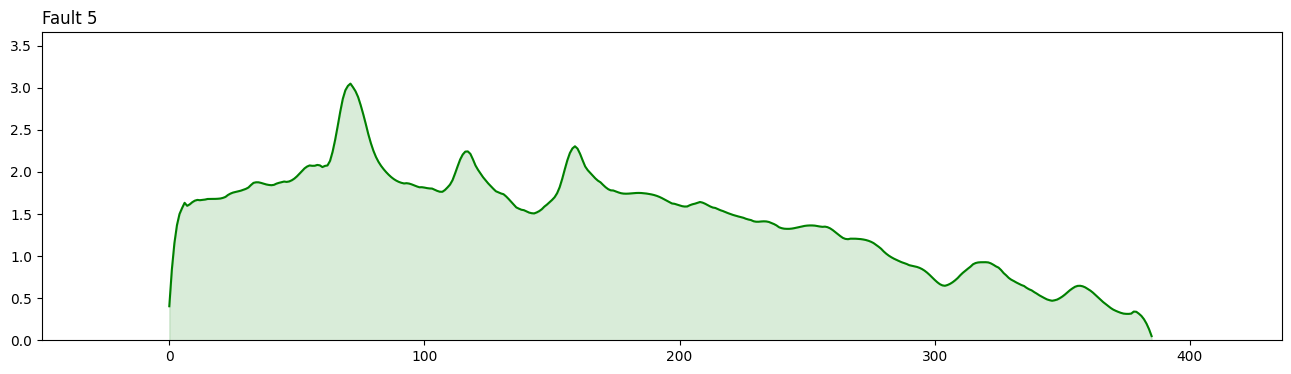

In [24]:
#myfid = 10 #selected fault ID
fault_throws = throws_all[myfid]
fault_throws = savgol_filter(fault_throws, 11, 3) #(OPTIONAL) apply a filter to smooth the curve and avoid sharp, unrealistic changes, window size 11, polynomial order 3

fig, ax = plt.subplots(1, 1, figsize=(16,4))
plt.plot(fault_throws, color='g')
ax.fill_between(range(len(fault_throws)),fault_throws,0, alpha=0.15, color='g')
ax.set_title('Fault '+str(myfid), loc='left')
ax.set_xlim([-50, len(fault_throws)+50])
ax.set_ylim([0, max(fault_throws)*1.2])

That looks good!

# 4. Fault evolution: displacement/length vs time

What is even cooler, is that we can add a few steps to do the same thing for ALL timesteps, and then visualise fault evolution over time.

First we have to loop through all timesteps in order to extract the elevation attribute and convert it into **Throw**, like this:

In [25]:
H_dem = [] #create a different list to avoid overwriting/issues with the original G_dem variable where all graphs are stored

for time in range(len(G_dem)):

  P_up = Ps[time] #grab the pick up points for each time step
  DEM = blurdems[time] #grab the smoothed digital elevation models for each time step
  G = G_dem[time] #grab the fault network for each time step
  P_up = metrics.extract_attribute(P_up, DEM, 'elevation') #this function collects values from the second argument based on the location of the first argument, and saves it as a new attribute

  #we calculate the difference in elevation
  for node in G:
    G.nodes[node]['difference'] = P_up.nodes[(node,1)]['elevation'] - P_up.nodes[(node,2)]['elevation']

  for comp in nx.connected_components(G):
    value = np.mean([G.nodes[node]['difference'] for node in comp])
  for node in comp:
    G.nodes[node]['mean_difference'] = value

  #dip direction
  threshold = 0.1
  for comp in nx.connected_components(G):
    value = np.mean([G.nodes[node]['difference'] for node in comp])
    if value > threshold:
      for node in comp:
        G.nodes[node]['dip_dir_auto'] = -1
    elif value < -threshold:
      for node in comp:
        G.nodes[node]['dip_dir_auto'] = 1
    else:
      for node in comp:
        G.nodes[node]['dip_dir_auto'] = 0

  #get the throws value using the specific function defined earlier
  G = get_throws(G, DEM, 1, plot_profiles=False)

  H_dem.append(G)

Now H_dem is a collection of graphs with all the fault throw data inside. We set up a loop so we can grab one single fault and get the throw profile over time:

Select fault ID: 
5


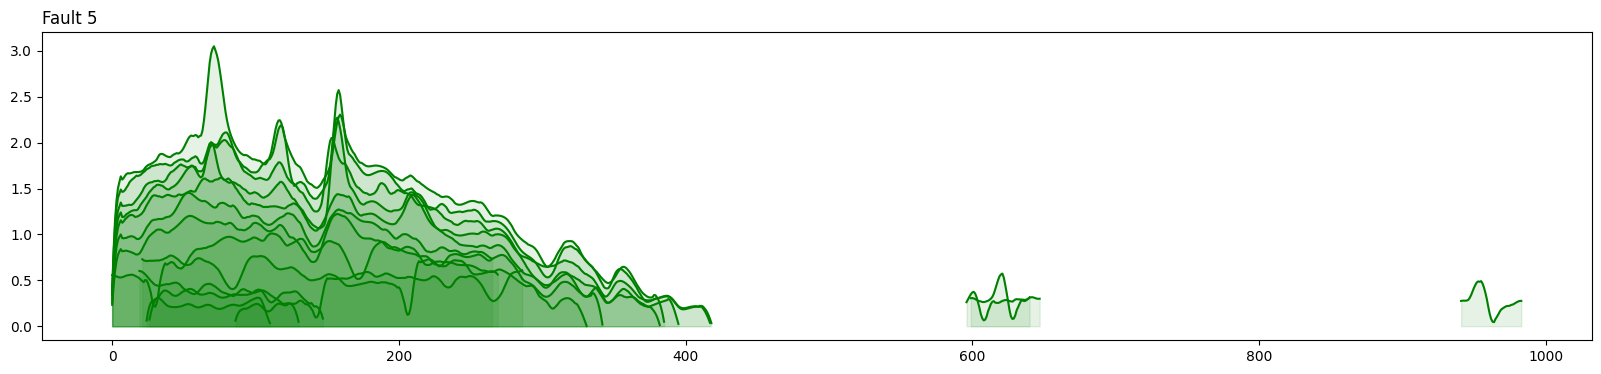

In [26]:
print('Select fault ID: ')
myfid=int(input())

#myfid = 12 #choose a fault ID

#set up a few things first
maxtime = len(H_dem)-1 #get the length of the list so we automatically get how many timesteps we are working with
H = H_dem[maxtime] #grab the final graph, as we will have the highest value for a fault ID here
maxlabels = get_fault_labels(H) #get all fault labels for this graph
throws_all = [None] * (max(maxlabels)+1) #create an empty array long as the max fault id, add 1 to avoid size issues later on

#set up the plot
fig, ax = plt.subplots(1, 1, figsize=(20,4))

#start the loop
for time in range(len(H_dem)):
  G = H_dem[time]
  labels = get_fault_labels(G) #get all fault labels for this graph

  for label in labels:

    myfault = metrics.get_fault(G,label) #get one fault at a time

    fault_throws = [] #create empty array where we'll append all the throw values for that fault
    for node in myfault.nodes: #grab each node on that fault
      thr = myfault.nodes[node]['throw'] #retrieve the throw value
      fault_throws.append(thr) #append to the empty array
    throws_all[label] = fault_throws #store each fault_throw profile into the main array

  if myfid in labels:
    myfault = metrics.get_fault(G,myfid)
    #get profile with throw values
    profile = np.array(throws_all[myfid])
    profile = savgol_filter(profile, 11, 3) #(OPTIONAL) apply a filter to smooth the curve, window size 11, polynomial order 3

    pos_profile = np.arange(0,len(profile)) #we create an array with the same length as the profile with throw values to avoid a size error

    #we need to create another array to use as the X-axis values, which correspond to the position of the fault trace in the map

    nodes_list = []
    for node in myfault.nodes:
      pos = myfault.nodes[node]['pos'][1] #we get Y-position attribute, for all nodes
      nodes_list.append(pos)
    pos_nodes = np.array(list(nodes_list)) #convert into an array from a list so I can use indexing or just handle the array easily
    min_pos = min(pos_nodes) #get minimum y position

    if min_pos == 0:
      pos_profile = np.arange(0,len(profile))
    else:
      pos_profile = np.arange(min_pos,min_pos+len(profile))

    #plot
    plt.plot(pos_profile, profile, color='g')
    ax.fill_between(pos_profile,profile,0, alpha=0.1, color='g')
    ax.set_title('Fault '+str(myfid), loc='left')
    #ax.set_ylim([0, max(profile)*1.1])

  else: #if the fault ID is not found, then it means that the fault does not exist yet!
    print('Fault ' + str(myfid) + ' not yet developed at time step ' + str(time))

plt.savefig(Path(str(str(loc_plots) + 'fault'+ str(myfid)+'DL_stack'+'.png')), dpi=200,transparent=True)

Not bad!
_______

We can plot the fault network again to compare top-view evolution with the graph we just created.

In [27]:
def f(time):
    H = H_dem[time] #grab graph corresponding to each timestep
    labels = get_fault_labels(H) #get all fault labels for this graph

    fig, axs = plt.subplots(1, 1, figsize=(4,10)) #set up plot

    axs.set_title('Fault network + DEM')
    axs.imshow(dems[time], 'gist_earth', vmin=-8, vmax=2, alpha=0.4) #plot DEM
    axs.imshow(es.hillshade(dems[time]), 'gist_earth', vmin=-8, vmax=2, alpha=0.4) #plot hillshade
    plots.plot_faults(H, node_size=1, ax=axs, label=True) #plot faults
    axs.set_ylim([1000,0])
    axs.set_xlim([0,400])

    #following lines could be turned into a fx to create a bounding box around the fault of interest
    if myfid in labels: #only do the following if my fault already exists
    # Create a Rectangle patch highlighting the fault location
      myfault = metrics.get_fault(H,myfid) #select the fault of interest

      xposs = [] #empty list where we will append all the positions in x
      yposs = [] #empty list where we will append all the positions in y

      for node in myfault.nodes:
        ypos = myfault.nodes[node]['pos'][0]
        yposs.append(ypos)
        xpos = myfault.nodes[node]['pos'][1]
        xposs.append(xpos)

      minxpos = min(xposs)
      maxxpos = max(xposs)
      h = abs(minxpos-maxxpos)
      minypos = min(yposs)
      maxypos = max(yposs)
      w = abs(minypos-maxypos)

      # Create and add the bounding box to our plot
      rect = patches.Rectangle((minypos-10,minxpos-10), w+20, h+20, linewidth=2, edgecolor='r', facecolor='r', alpha=0.2)
      axs.add_patch(rect)
      # And a little arrow
      axs.arrow(minypos-35,minxpos-60,25,50,color='r',width=1,head_width=8,zorder=2)
    else:
      print('Fault ' + str(myfid) + ' not yet developed at time step ' + str(time))

    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=0, max=15, step=1, layout=Layout(width='700px')))
output = interactive_plot.children[-1]
output.layout.width = '800px'
interactive_plot

interactive(children=(IntSlider(value=0, description='time', layout=Layout(width='700px'), max=15), Output(lay…

Fault network from time 0 to end, whole map

In [28]:
def f(time):
    H = H_dem[time] #grab graph corresponding to each timestep
    labels = get_fault_labels(H) #get all fault labels for this graph

    fig, axs = plt.subplots(1, 1, figsize=(4,10)) #set up plot

    axs.set_title(str('Time '+str(time)))
    axs.imshow(dems[time], 'gist_earth', vmin=-8, vmax=2, alpha=0.4) #plot DEM
    axs.imshow(es.hillshade(dems[time]), 'gist_earth', vmin=-8, vmax=2, alpha=0.4) #plot hillshade
    plots.plot_faults(H, node_size=1, ax=axs, label=True) #plot faults
    axs.set_ylim([1000,0])
    axs.set_xlim([0,400])

    #plt.savefig(Path(str(str(loc_plots) + str(time) +'.png')), dpi=200)
    #plt.close("all")

for time in range(0,16,1):
  f(time)



Output hidden; open in https://colab.research.google.com to view.

In [29]:
nodes = [node for node in H if H.nodes[node]['fault']==58]
print(nodes)

[6178, 6179, 6180, 6181, 6182, 6183, 6184, 6185, 6186, 6187, 6188, 6189, 6190, 6191, 6192, 6193, 6194, 6195, 6196, 6197, 6198, 6199, 6200, 6201, 6202, 6203, 6204, 6205, 6206, 6207, 6208, 6209, 6210, 6211, 6212, 6213, 6214, 6215, 6216, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225, 6226, 6227, 6228, 6229, 6230, 6231, 6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247, 6248, 6249, 6250, 6251, 6252, 6253, 6254, 6255, 6256, 6257, 6258, 6259, 6260, 6261, 6262, 6263, 6264, 6265, 6266, 6267, 6268, 6269, 6270, 6271, 6272, 6273, 6274, 6275, 6276, 6277, 6278, 6279, 6280, 6281, 6282, 6283, 6284, 6285, 6286, 6287, 6288, 6289, 6290, 6291, 6292, 6293, 6294, 6295, 6296, 6297, 6298, 6299, 6300, 6301, 6302, 6303, 6304, 6305, 6306, 6307, 6308, 6309, 6310, 6311, 6312, 6313, 6314, 6315, 6316, 6317, 6318, 6319, 6320, 6321, 6322, 6323, 6324, 6325, 6326, 6327, 6328, 6329, 6330, 6331, 6332, 6333, 6334, 6335, 6336, 6337, 6338, 6339, 6340, 6341, 6342, 6343, 634

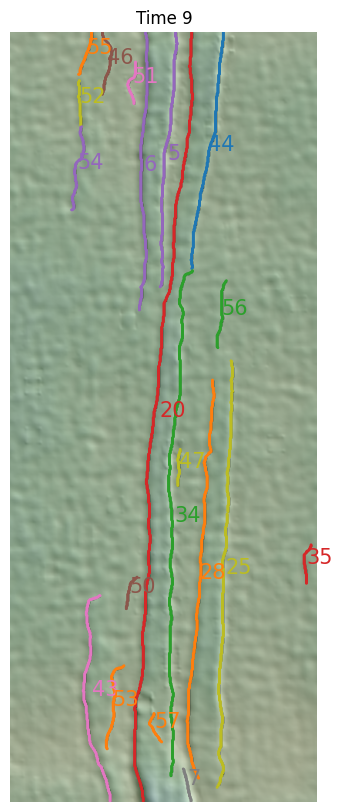

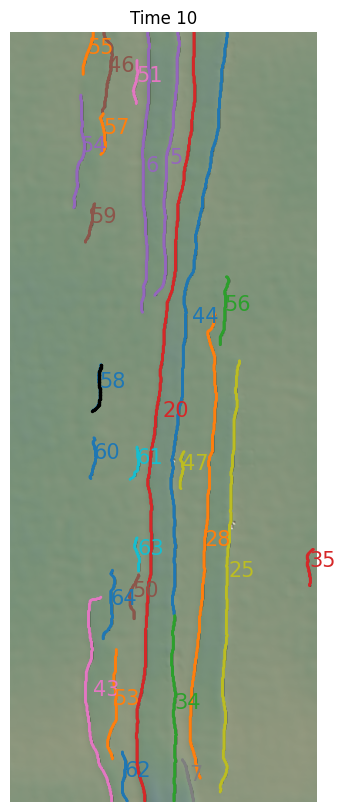

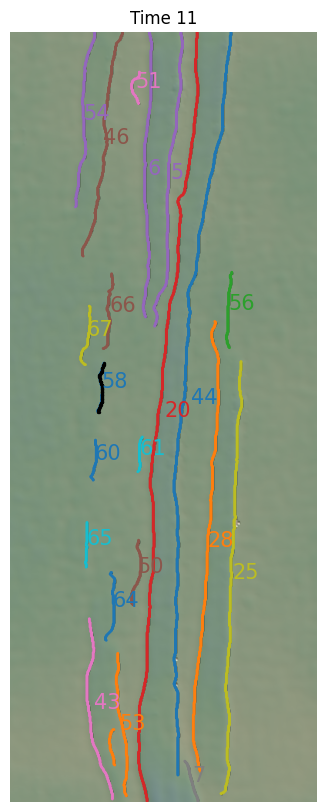

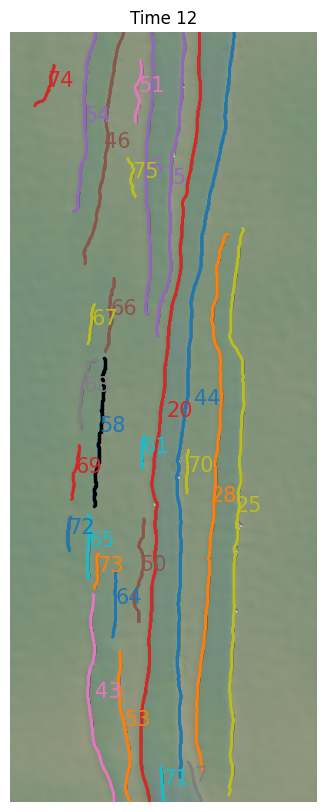

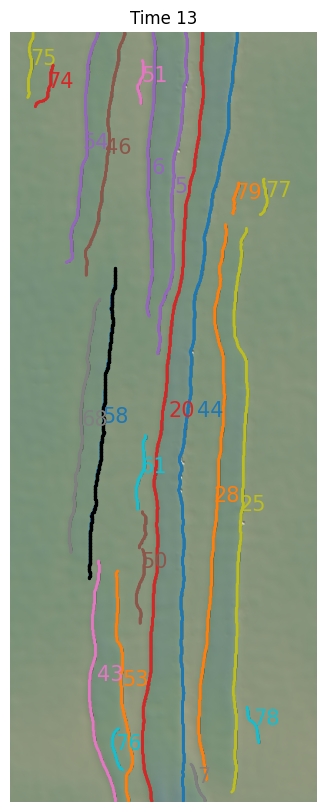

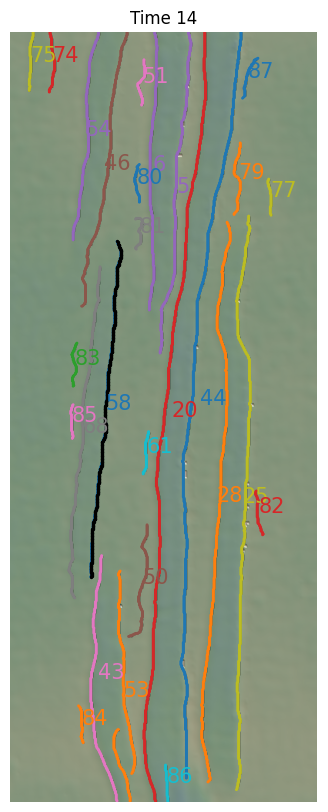

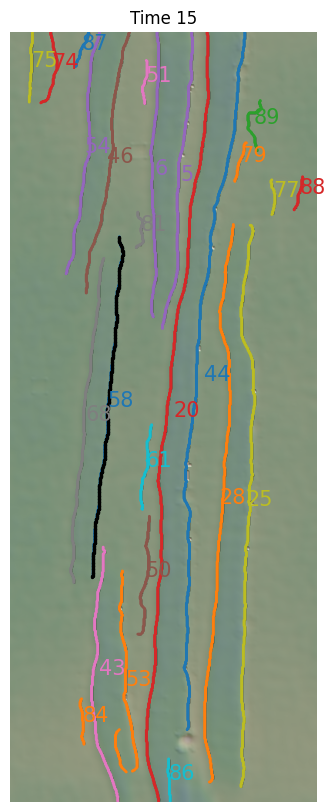

In [30]:
#adapt with plot fault 58 in black

def f(time):
    H = H_dem[time] #grab graph corresponding to each timestep
    labels = get_fault_labels(H) #get all fault labels for this graph
    nodes = [node for node in H if H.nodes[node]['fault']==58]
    K=nx.subgraph(H,nodes) # K is a subgraph containing only one component

    fig, axs = plt.subplots(1, 1, figsize=(4,10)) #set up plot

    axs.set_title(str('Time '+str(time)))

    axs.imshow(dems[time], 'gist_earth', vmin=-8, vmax=2,alpha=0.6) #plot DEM
    axs.imshow(es.hillshade(dems[time]), 'Greys',alpha=0.5) #plot hillshade
    #axs.imshow(es.hillshade(dems[time]), 'gist_earth', vmin=-8, vmax=2, alpha=0.6) #plot hillshade
    plots.plot_faults(H, node_size=1, ax=axs, label=True) #plot faults

    nx.draw(K, pos=nx.get_node_attributes(K, 'pos'), ax=axs, node_color='#000000',node_size=2)

    axs.set_ylim([1000,0])
    axs.set_xlim([0,400])

    plt.savefig(Path(str(str(loc_plots) + str(time) +'.png')), dpi=200)
    #plt.close("all")

for time in range(9,16,1):
  f(time)

[]


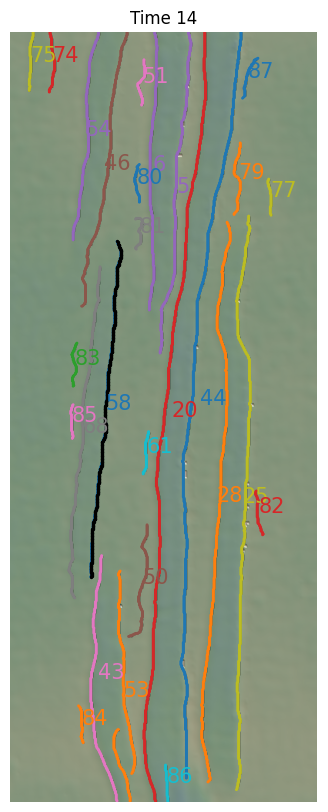

In [31]:
time=14
f(time)
H = H_dem[time]
nodes = [node for node in H if H.nodes[node]['component']==58]
K=nx.subgraph(H,nodes) # K is a subgraph containing only one component
nx.draw(K, pos=nx.get_node_attributes(K, 'pos'), node_color='#000000',node_size=400)
print(K.nodes)

In [32]:
# Convert pngs to mp4
import imageio
fileList = []
for file in range(0,16,1):
    fileList.append(str(str(str(loc_plots) + str(file) +'.png')))

writer = imageio.get_writer(str(str(loc_plots)+ 'fault_network' + '.mp4'), fps=1)

for im in fileList:
    image = imageio.imread(im)
    #image = iio.v3.imread(im)
    writer.append_data(image)
writer.close()

/tmp/ipython-input-1625920944.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(im)


In [33]:
str(str(loc_plots)+ 'fault_network' + '.mp4')

'/content/drive/MyDrive/Fatbox/tutorials/analog/plots/B2fault_network.mp4'

D/L profile successives from  0 to end,  for a single fault

Fault 58 not yet developed at time step 0
Fault 58 not yet developed at time step 1
Fault 58 not yet developed at time step 2
Fault 58 not yet developed at time step 3
Fault 58 not yet developed at time step 4
Fault 58 not yet developed at time step 5
Fault 58 not yet developed at time step 6
Fault 58 not yet developed at time step 7
Fault 58 not yet developed at time step 8
Fault 58 not yet developed at time step 9


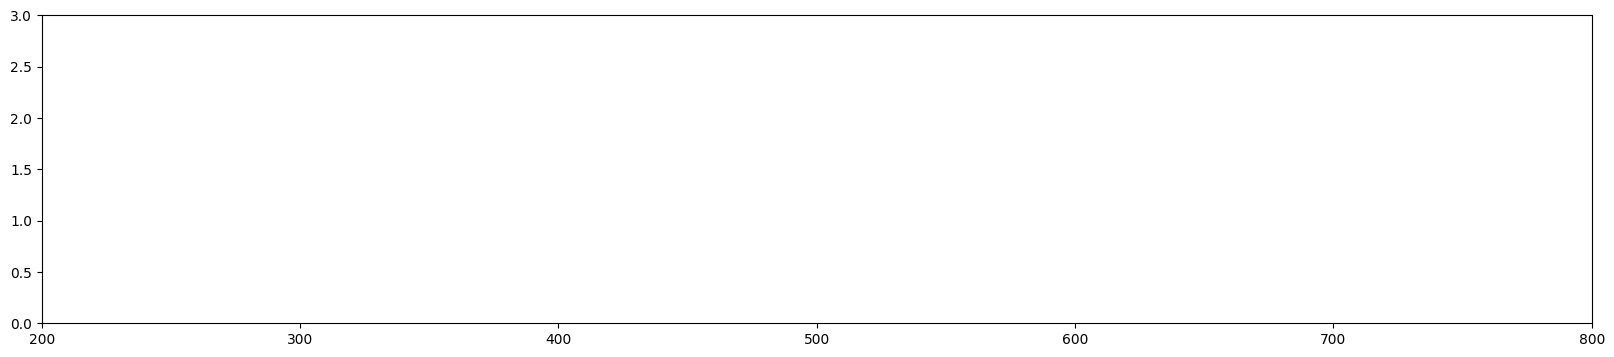

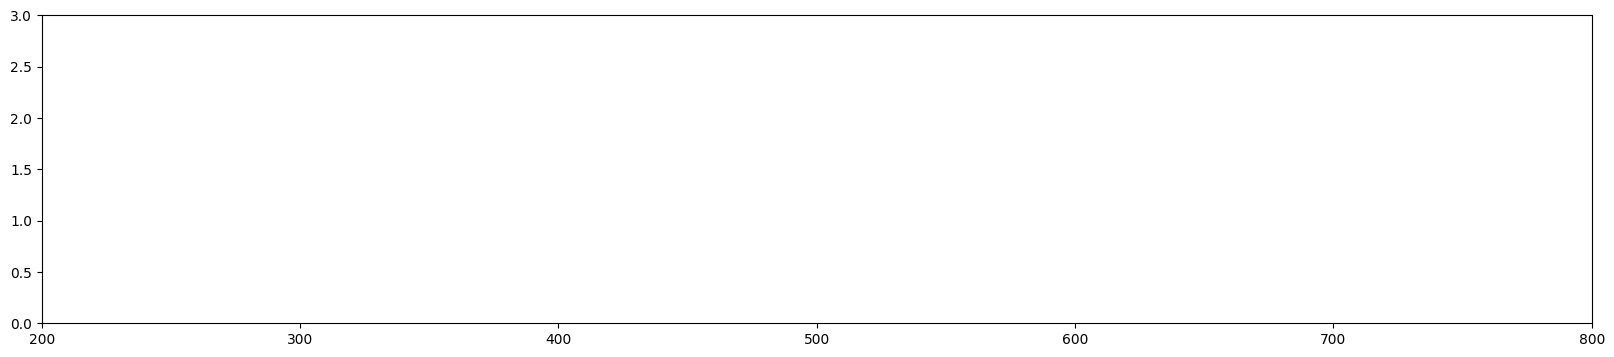

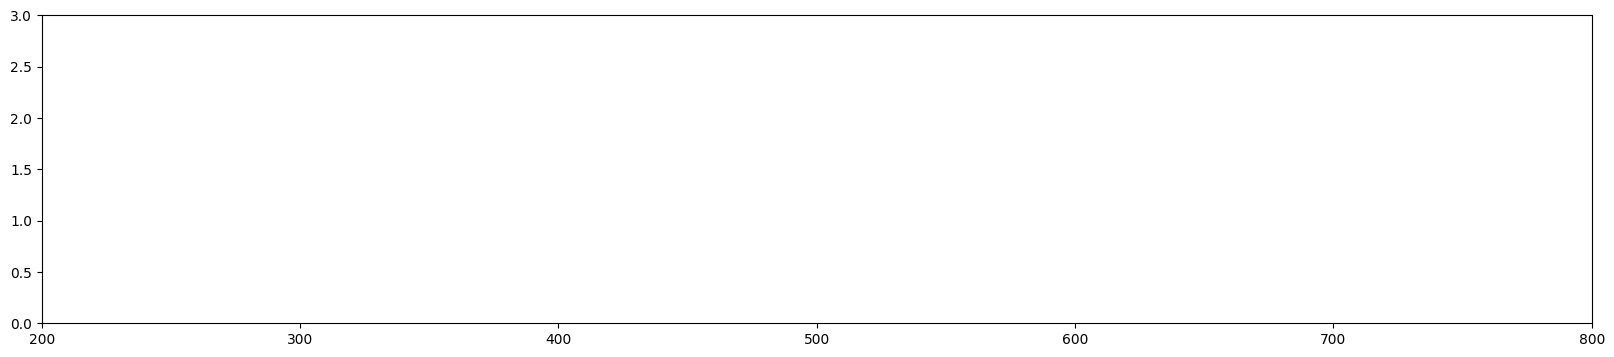

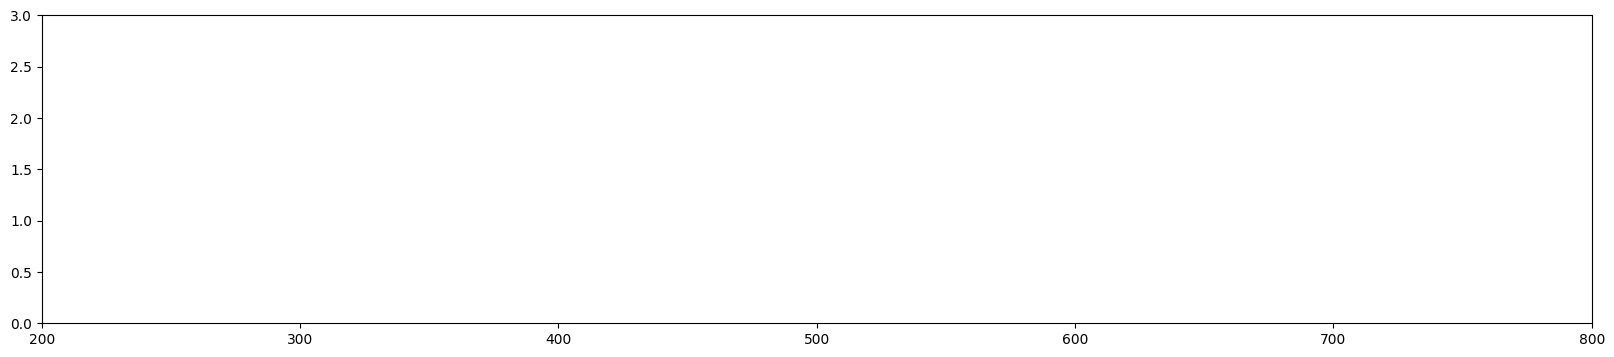

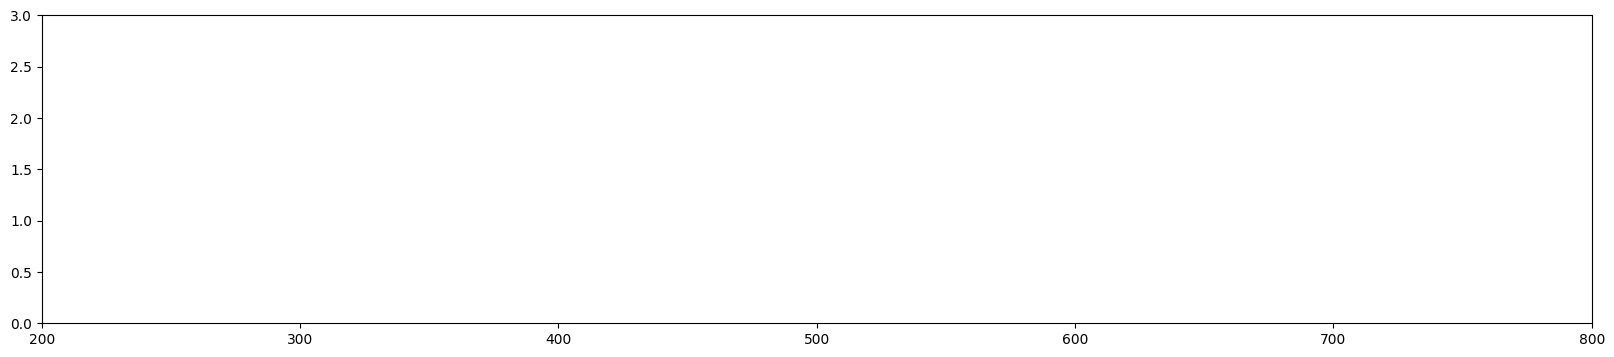

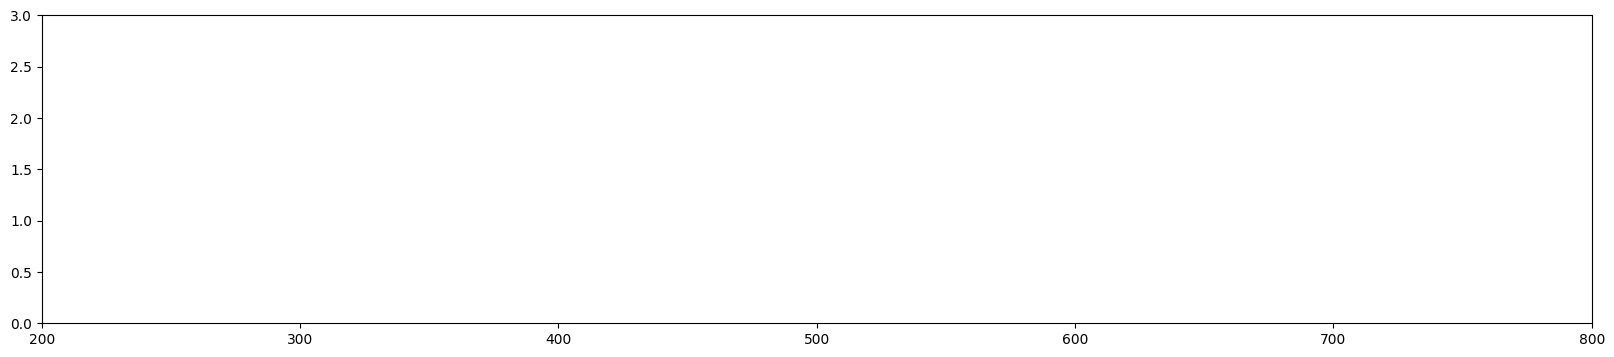

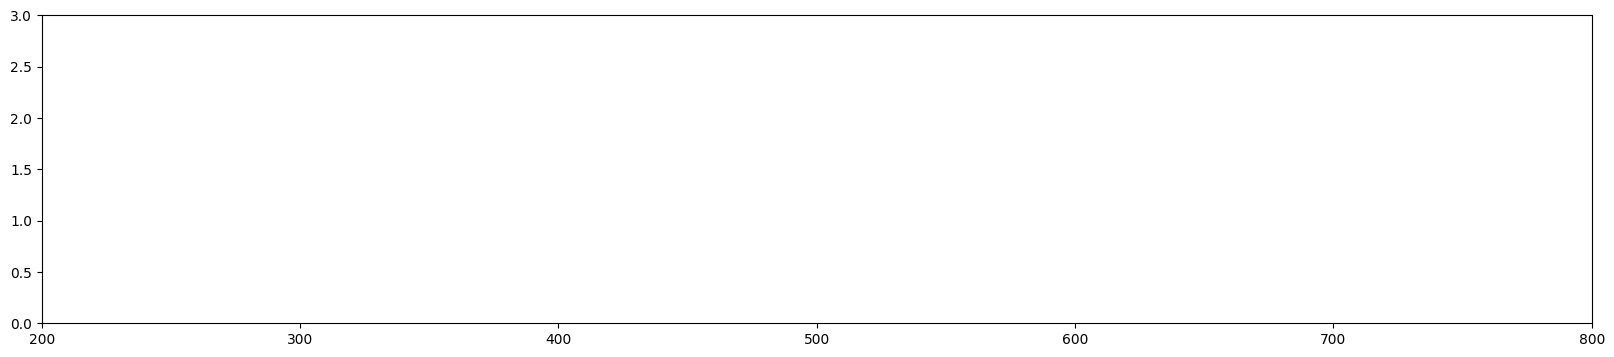

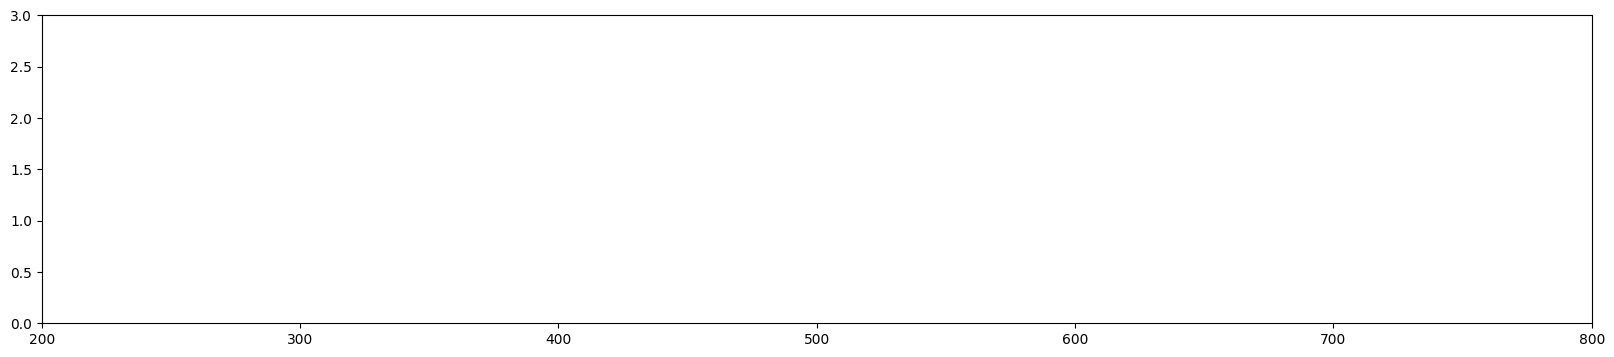

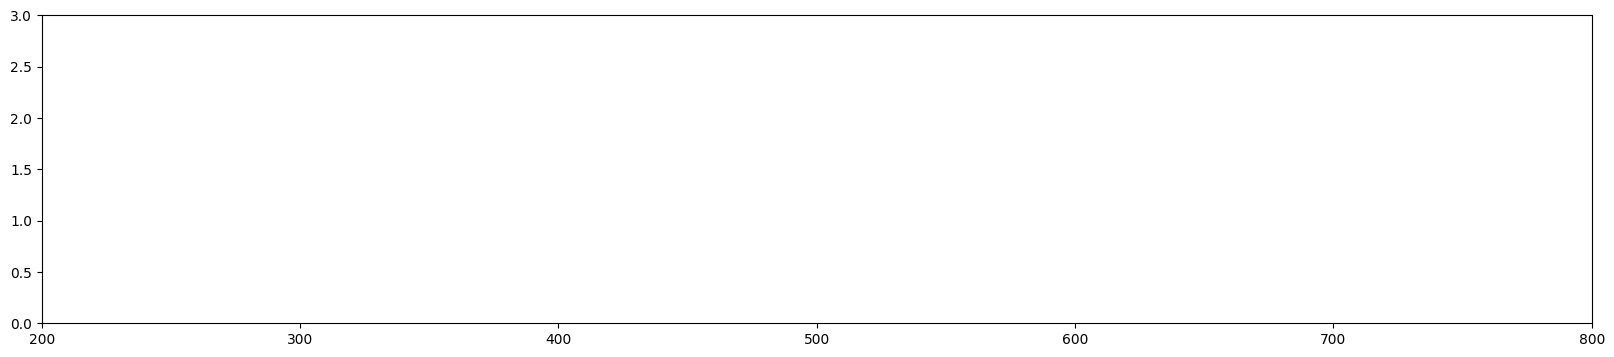

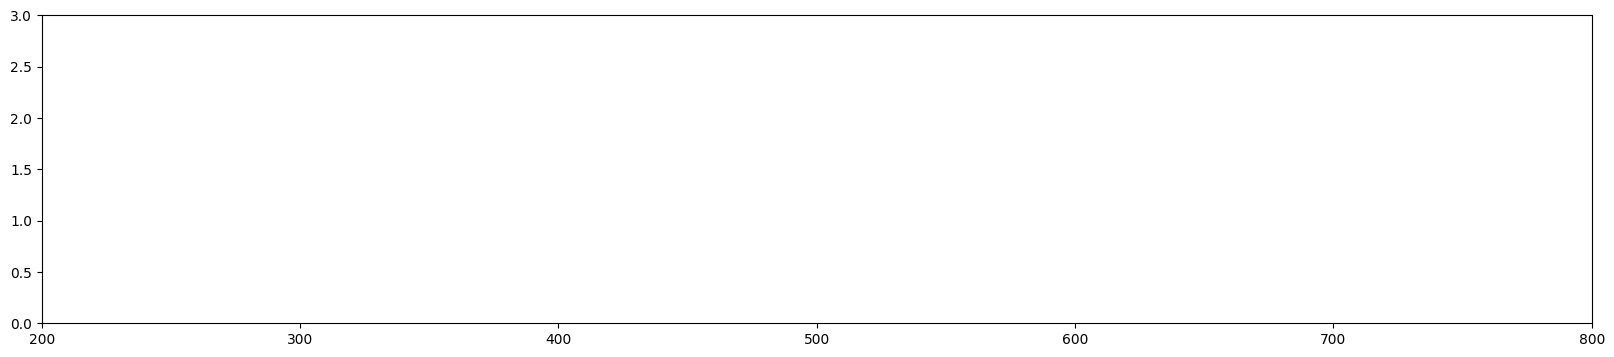

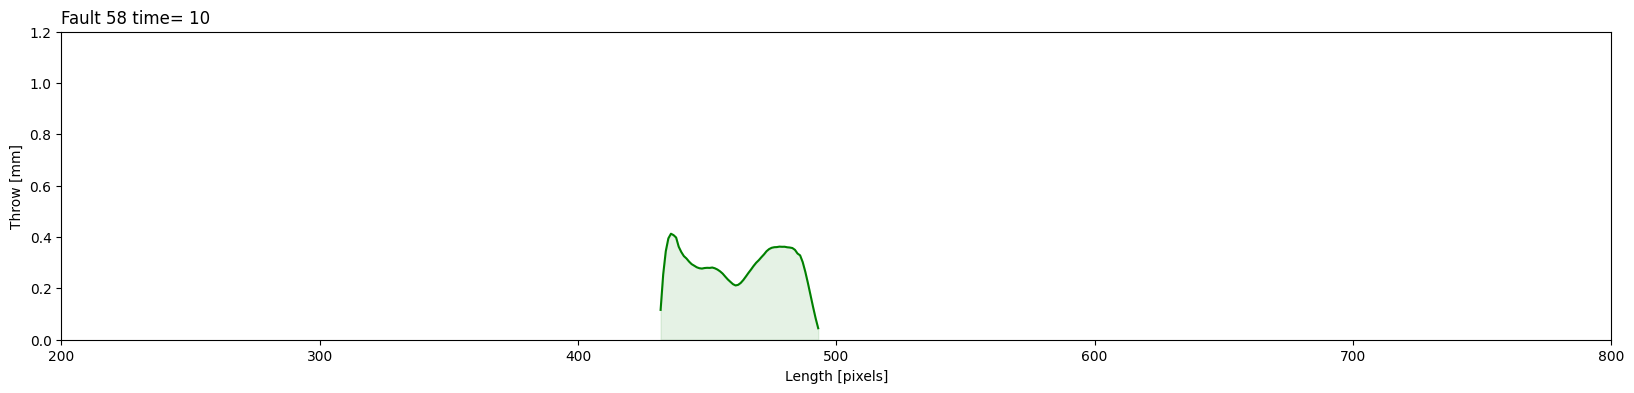

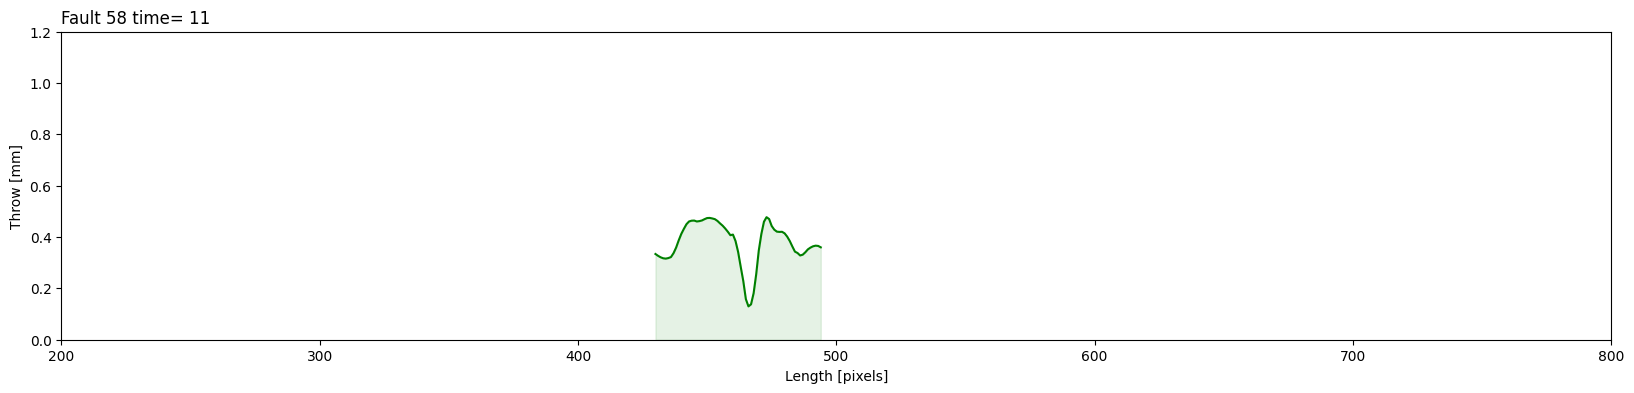

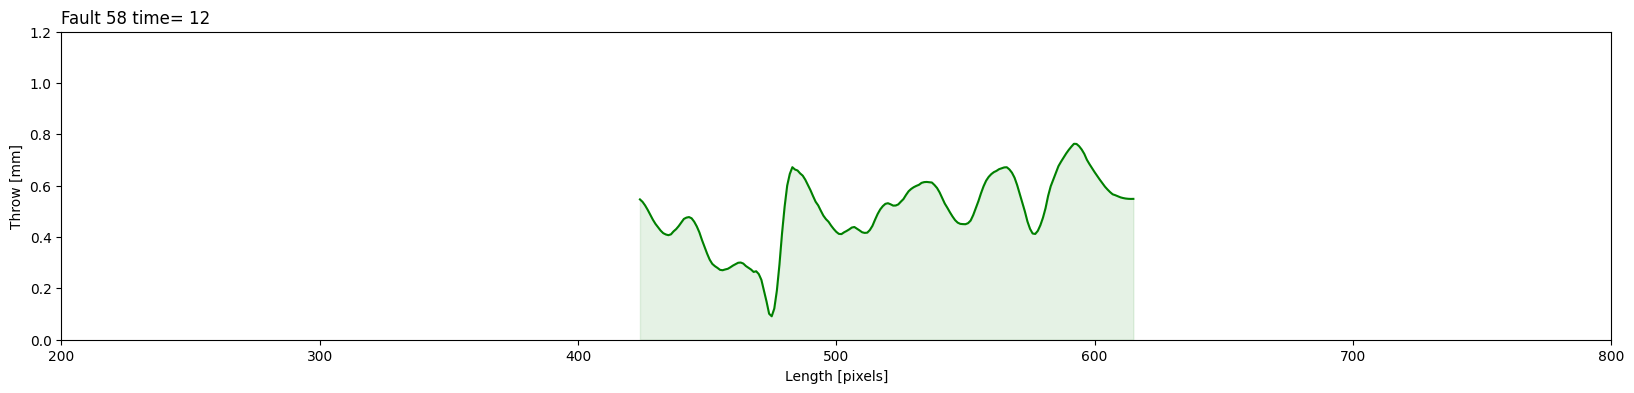

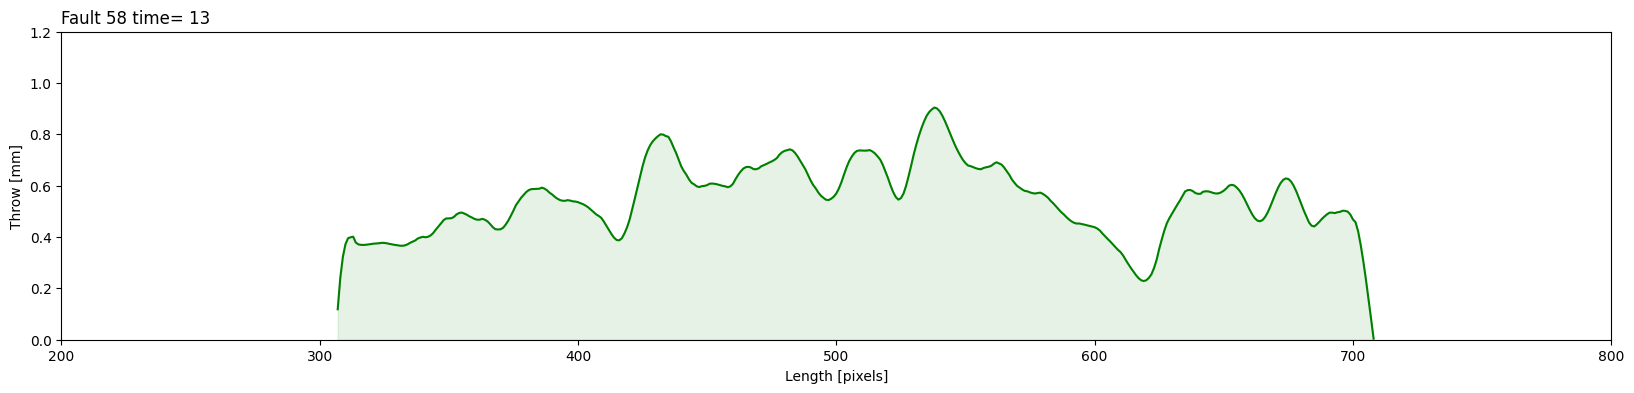

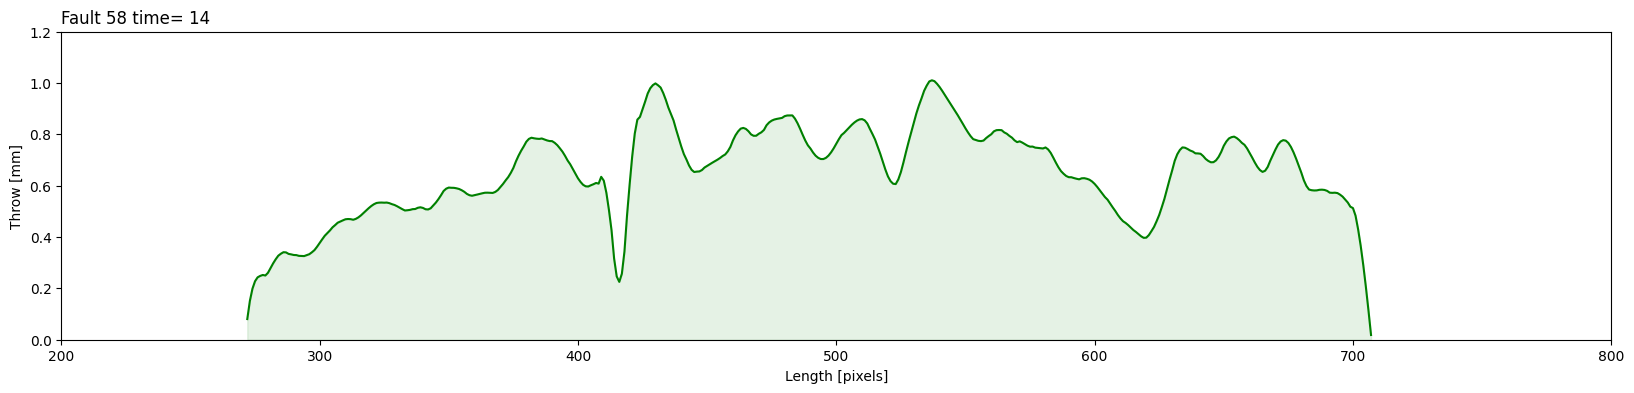

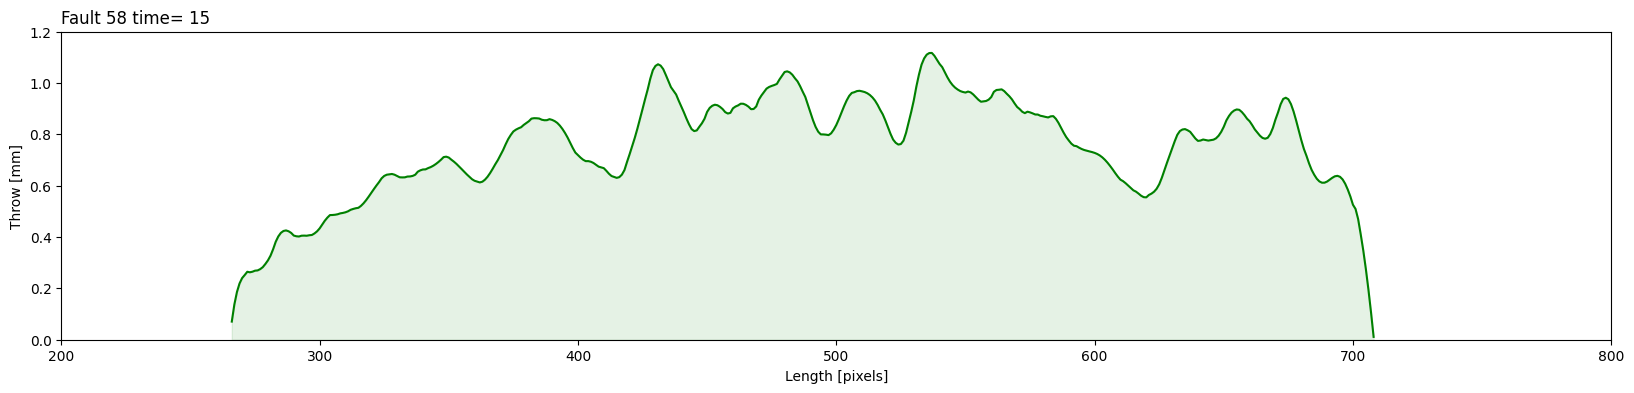

In [34]:

## FOR FIGURE
# plot less curves

myfid=int(58)

#myfid = 12 #choose a fault ID

#set up a few things first
maxtime = len(H_dem)-1 #get the length of the list so we automatically get how many timesteps we are working with
H = H_dem[maxtime] #grab the final graph, as we will have the highest value for a fault ID here
maxlabels = get_fault_labels(H) #get all fault labels for this graph
throws_all = [None] * (max(maxlabels)+1) #create an empty array long as the max fault id, add 1 to avoid size issues later on

#set up the plot
#fig, ax = plt.subplots(1, 1, figsize=(20,4))
#ax.set_xlim([0,1000])
#ax.set_ylim([0,3])

#start the loop
for time in range(0,16,1):
  fig, ax = plt.subplots(1, 1, figsize=(20,4))
  ax.set_xlim([200,800])
  ax.set_ylim([0,3])

  G = H_dem[time]
  labels = get_fault_labels(G) #get all fault labels for this graph

  for label in labels:

    myfault = metrics.get_fault(G,label) #get one fault at a time

    fault_throws = [] #create empty array where we'll append all the throw values for that fault
    for node in myfault.nodes: #grab each node on that fault
      thr = myfault.nodes[node]['throw'] #retrieve the throw value
      fault_throws.append(thr) #append to the empty array
    throws_all[label] = fault_throws #store each fault_throw profile into the main array

  if myfid in labels:
    myfault = metrics.get_fault(G,myfid)
    #get profile with throw values
    profile = np.array(throws_all[myfid])
    profile = savgol_filter(profile, 11, 3) #(OPTIONAL) apply a filter to smooth the curve, window size 11, polynomial order 3

    pos_profile = np.arange(0,len(profile)) #we create an array with the same length as the profile with throw values to avoid a size error

    #we need to create another array to use as the X-axis values, which correspond to the position of the fault trace in the map

    nodes_list = []
    for node in myfault.nodes:
      pos = myfault.nodes[node]['pos'][1] #we get Y-position attribute, for all nodes
      nodes_list.append(pos)
    pos_nodes = np.array(list(nodes_list)) #convert into an array from a list so I can use indexing or just handle the array easily
    min_pos = min(pos_nodes) #get minimum y position

    if min_pos == 0:
      pos_profile = np.arange(0,len(profile))
    else:
      pos_profile = np.arange(min_pos,min_pos+len(profile))

    #plot
    plt.plot(pos_profile, profile, color='g')
    ax.fill_between(pos_profile,profile,0, alpha=0.1, color='g')
    ax.set_title('Fault '+str(myfid)+ ' time= '+str(time), loc='left')
    ax.set_ylabel('Throw [mm]')
    ax.set_xlabel('Length [pixels]')
    #ax.set_ylim([0, max(profile)*1.1])
    ax.set_ylim([0, 1.2])

  else: #if the fault ID is not found, then it means that the fault does not exist yet!
    print('Fault ' + str(myfid) + ' not yet developed at time step ' + str(time))

  plt.savefig(Path(str(str(loc_plots) + 'fault'+ str(myfid)+'DL_'+str(time) +'.png')), dpi=200,transparent=True)
  #plt.close("all")




In [35]:
# Convert pngs to mp4
import imageio
myfid=5
fileList = []
for file in range(0,16,1):
    fileList.append(str(str(loc_plots) + 'fault'+ str(myfid)+'DL_'+str(file) +'.png'))

writer = imageio.get_writer(str(str(loc_plots)+'fault'+str(myfid)+'DL' + '.mp4'), fps=1)

for im in fileList:
    image = imageio.imread(im)
    #image = iio.v3.imread(im)
    writer.append_data(image)
writer.close()

/tmp/ipython-input-1286412299.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(im)


In [36]:
str(str(loc_plots)+ 'DL' + '.mp4')

'/content/drive/MyDrive/Fatbox/tutorials/analog/plots/B2DL.mp4'